# Amazon sentiment analysis: FEDA
Method based on the [frustratingly easy domain adaptation](http://legacydirs.umiacs.umd.edu/~hal/docs/daume07easyadapt.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from read_funcs import organise_data, vectorise_data, select_high_freq_data

In [2]:
src = 'dvd'
tgt = 'kitchen'
XB, Y_src, XD, Y_tgt = organise_data(src, tgt)

dvd 1000 -1000
kitchen 1000 -1000


In [3]:
# Vectorise the raw data
X_src, X_tgt, features = vectorise_data(XB, XD)
# Reduce the no. of features
N = 10000
X_src, X_tgt, features = select_high_freq_data(X_src, X_tgt, features, N)

In [4]:
print(features[-20:])

['about', 'his', 'great', 'out', 'very', 'like', 'just', 'if', 'film', 'all', 'so', 'they', 'my', 'movie', 'one', '<num>', 'not', 'you', 'was', 'i']


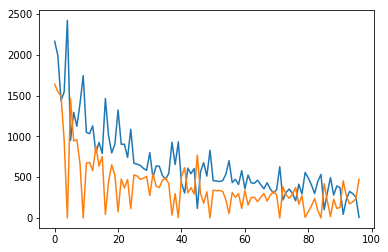

In [5]:
B_count = np.sum(X_src,0)
D_count = np.sum(X_tgt,0)
plt.plot(B_count[-3:-100:-1])
plt.plot(D_count[-3:-100:-1])

In [6]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = 1) # Regularisation parameter C = 1
model.fit(X_src, Y_src)
print('train {:s} acc: {:.3f}, test {:s} acc: {:.3f}'\
      .format(src, model.score(X_src, Y_src), tgt, model.score(X_tgt,Y_tgt)))

train dvd acc: 1.000, test kitchen acc: 0.774


In [7]:
# Test the sensitivity to regularisation parameter
C_test = np.linspace(0.1,2,20)
acc_train = []
acc_dev = []
for C in C_test:
    model_BL = LogisticRegression(C = C,  penalty='l1') 
    model_BL.fit(X_src, Y_src)
    acc_train.append(model_BL.score(X_src, Y_src))
    acc_dev.append(model_BL.score(X_tgt, Y_tgt))

optimal alpha 0.4 train acc 0.95 max acc 0.7675


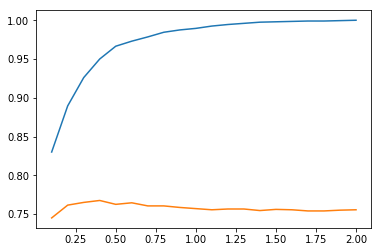

In [8]:
C_opt = C_test[np.argmax(acc_dev)]
model_L1 = LogisticRegression(C = C_opt,  penalty='l1') 
model_L1.fit(X_src, Y_src)
print('optimal alpha', C_opt, 'train acc', model_L1.score(X_src, Y_src), 'max acc', max(acc_dev))
plt.plot(C_test, acc_train)
plt.plot(C_test, acc_dev)

In [9]:
coef_l1_LR = model_L1.coef_.ravel()
coef_l2_LR = model.coef_.ravel()
sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)

Sparsity with L1 penalty: 95.80%
Sparsity with L2 penalty: 6.04%


# FEDA with limited samples

In [10]:
def mean_error_fixed_size_FEDA(X_s, X_t, Y_s, Y_t, test_size, Nrepeat):
    Ns = np.size(X_s,0)
    n_t_l = test_size
    
    err_BL2 = []
    err_FEDA = []
    err_FEDA2 = []
    
    for i in range(Nrepeat):
        # get labeled target data
        X_tu, X_tl, Y_tu, Y_tl = train_test_split(X_t, Y_t, test_size = test_size, random_state = i)
        
        X_train_full = np.r_[X_s, X_tl]
        Y_train_full = np.r_[Y_s, Y_tl]
        # Baseline with target data
        model2_BL = LogisticRegression(C = 1)
        model2_BL.fit(X_train_full,Y_train_full)
        err_BL2.append(model2_BL.score(X_tu, Y_tu))
        
        # FEDA
        X_FEDA_src = np.c_[X_src, X_src, np.zeros(X_src.shape)]
        X_FEDA_tl = np.c_[X_tl,  np.zeros(X_tl.shape), X_tl]
        X_FEDA_tu = np.c_[X_tu,  np.zeros(X_tu.shape), X_tu]
        X_FEDA = np.r_[X_FEDA_src, X_FEDA_tl]
        model_FEDA = LogisticRegression(C = 1)
        model_FEDA.fit(X_FEDA,Y_train_full)
        err_FEDA.append(model_FEDA.score(X_FEDA_tu, Y_tu))
        
        # FEDA upweight
        weight = np.r_[np.ones(Ns), Ns/n_t_l*np.ones(n_t_l)]
        model_FEDA2 = LogisticRegression(C = 1)
        model_FEDA2.fit(X_FEDA,Y_train_full, weight)
        err_FEDA2.append(model_FEDA2.score(X_FEDA_tu, Y_tu))
        
    np.set_printoptions(precision=3)
    print('baseline src + lt:', np.asarray(err_BL2))
    print('FEDA', np.asarray(err_FEDA))
    print('upweighted FEDA', np.asarray(err_FEDA2))
    return [np.mean(err_BL2), np.mean(err_FEDA), np.mean(err_FEDA2)]  

In [11]:
test_size = 80
Nrepeat = 8
full_results = []
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size_FEDA(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test dvd to kitchen with labeled target size 80
baseline src + lt: [ 0.8    0.778  0.792  0.783  0.793  0.792  0.799  0.801]
FEDA [ 0.808  0.787  0.797  0.8    0.802  0.804  0.786  0.801]
upweighted FEDA [ 0.81   0.768  0.796  0.793  0.793  0.794  0.764  0.793]


In [12]:
test_size = 120
Nrepeat = 8
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size_FEDA(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test dvd to kitchen with labeled target size 120
baseline src + lt: [ 0.809  0.794  0.791  0.8    0.794  0.798  0.811  0.812]
FEDA [ 0.821  0.799  0.804  0.811  0.799  0.816  0.819  0.822]
upweighted FEDA [ 0.816  0.793  0.802  0.805  0.79   0.809  0.807  0.813]


In [13]:
test_size = 200
Nrepeat = 8
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size_FEDA(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test dvd to kitchen with labeled target size 200
baseline src + lt: [ 0.821  0.81   0.816  0.809  0.809  0.809  0.818  0.832]
FEDA [ 0.828  0.822  0.817  0.832  0.821  0.82   0.825  0.835]
upweighted FEDA [ 0.824  0.813  0.817  0.827  0.811  0.819  0.819  0.822]


In [14]:
results_summary = np.asarray(full_results)
results_summary.shape

(3, 3)

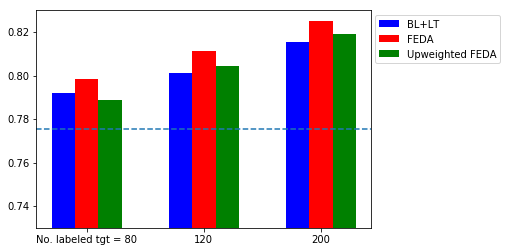

In [15]:
index = np.array([1, 2, 3])
bar_width = 0.2
color_list = ['blue','red', 'green', 'yellow','cyan']
label_list = ['BL+LT', 'FEDA', 'Upweighted FEDA']
for i in range(3):
    plt.bar(index + i*bar_width, results_summary[:,i], bar_width, \
            color = color_list[i], label = label_list[i])
plt.xticks(index + 1*bar_width, ('No. labeled tgt = 80','120', '200' ))
plt.ylim(0.73,0.83)
plt.axhline(y = 0.7755, ls = '--')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.savefig("AccFEDA_{}_to_{}.png".format(src,tgt), bbox_inches="tight")

### Examine the effectiveness of feature weights

In [16]:
test_size = 1000
X_train = np.c_[X_src, X_src, np.zeros(X_src.shape)]
X_train_tgt = np.c_[X_tgt,  np.zeros(X_tgt.shape), X_tgt]
X_train = np.r_[X_train, X_train_tgt]
Y_train = np.r_[Y_src, Y_tgt]
model_FEDA = LogisticRegression(C = 1, penalty='l1') # Regularisation parameter C = 1
model_FEDA.fit(X_train, Y_train)
print('training acc: {:.3f}'.format(model_FEDA.score(X_train, Y_train)))

training acc: 0.995


In [17]:
weights = model_FEDA.coef_.ravel()

In [18]:
sort_idx_joint = np.argsort(weights[:np.size(X_tgt,1)])
sort_idx_joint = sort_idx_joint.reshape((-1, 1))

In [19]:
print([features[i[0]] for i in sort_idx_joint[-20:]])
print([features[i[0]] for i in sort_idx_joint[:20]])

['love', 'loves', 'going_strong', 'great', 'be_disappointed', 'intense', 'amazing', 'unique', 'fantastic', 'my_only', 'i_decided', 'perfect', 'cool', 'best', 'a_must', 'keeps', 'seen_it', 'enjoy', 'excellent', 'not_only']
['disappointment', 'disappointing', 'worst', 'horrible', 'waste', 'awful', 'not_worth', 'terrible', 'started', 'a_much', 'sucks', 'poorly', 'threw', 'returned', 'crap', 'ever_seen', 'worse', 'dangerous', 'found_the', 'disappointed']


In [20]:
sort_idx_dvd = np.argsort(weights[np.size(X_tgt,1):np.size(X_tgt,1)*2])
sort_idx_dvd = sort_idx_dvd.reshape((-1, 1))

In [21]:
print([features[i[0]] for i in sort_idx_dvd[-20:]])
print([features[i[0]] for i in sort_idx_dvd[:20]])

['although_i', 'band', 'probably', 'bonus', 'classic', 'between', 'gem', 'anyone', 'also', 'gives', 'still', 'always', 'missing', 'hope', 'behind', 'generation', 'watching_the', 'lot_of', 'and_some', 'better_than']
['lame', 'stay', 'boring', "they're", 'chinese', 'dull', "i'd", "i_don't", 'except', 'make', 'lower', 'charm', 'away', 'version', 'reviews', 'character_in', 'submarine', 'misery', 'no', 'kitty']


In [22]:
sort_idx_kitchen = np.argsort(weights[np.size(X_tgt,1)*2:np.size(X_tgt,1)*3])
sort_idx_kitchen = sort_idx_kitchen.reshape((-1, 1))
print([features[i[0]] for i in sort_idx_kitchen[-20:]])
print([features[i[0]] for i in sort_idx_kitchen[:20]])

['and_very', 'of_your', 'nice', 'some', 'stars', 'dust', 'need_to', "couldn't", 'quiet', 'now_and', 'so_far', 'that_we', 'works', 'perfect', 'the_only', 'durable', 'comes', 'tool', 'perfectly', 'easy']
['broken', 'packs', 'returning', 'idea', 'thin', 'thermometer', 'bargain', 'you_have', 'tried_to', 'broke', 'poor', 'disappointed', 'temperature', 'table', 'too', 'followed', 'expect', 'between_the', 'product_is', 'grip']
